In [1]:
import numpy as np  # this module handles arrays, but here we need it for its NaN value
import pandas as pd # this module contains a lot of tools for handling tabular data
from matplotlib import pyplot as plt
from salishsea_tools import evaltools as et
import datetime as dt
import os
import gsw
import pickle
import netCDF4 as nc
import cmocean
from scipy import stats as spst
%matplotlib inline

In [2]:
modSourceDir= '/results/SalishSea/nowcast-green.201812/'
modver='201812'
Chl_N=1.8 # Chl:N ratio

In [3]:
# Parameters
modSourceDir = "/results2/SalishSea/nowcast-green.201905/"
modver = "201905"
Chl_N = 1.8


In [4]:
def subval(idf,colList):
    # first value in colList should be the column you are going to keep
    # follow with other columns that will be used to fill in when that column is NaN
    # in order of precedence
    if len(colList)==2:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] for i,r in idf.iterrows()]
    elif len(colList)==3:
        idf[colList[0]]=[r[colList[0]] if not pd.isna(r[colList[0]]) \
                         else  r[colList[1]] if not pd.isna(r[colList[1]]) \
                         else r[colList[2]] for i,r in idf.iterrows()]
    else:
        raise NotImplementedError('Add to code to handle this case')
    idf.drop(columns=list(colList[1:]),inplace=True)
    return idf

In [5]:
if os.path.isfile('matched_'+modver+'.pkl'):
    data=pickle.load(open( 'matched_'+modver+'.pkl', 'rb' ) )
else:
    # define paths to the source files and eventual output file
    flist=('/ocean/eolson/MEOPAR/obs/Nina/bottlePhytoMerged2015.csv',
           '/ocean/eolson/MEOPAR/obs/Nina/bottlePhytoMerged2016.csv',
           '/ocean/eolson/MEOPAR/obs/Nina/bottlePhytoMerged2017.csv',
           '/ocean/eolson/MEOPAR/obs/Nina/bottlePhytoMerged2018.csv')

    dfs=list()
    for fname in flist:
        idf=pd.read_csv(fname)
        print(fname,sorted(idf.keys()))
        dfs.append(idf)
    df=pd.concat(dfs,ignore_index=True,sort=False); # concatenate the list into a single table

    df.drop(labels=['ADM:MISSION','ADM:PROJECT','ADM:SCIENTIST','Zone','Zone.1','Temperature:Draw',
                    'Temperature:Draw [deg C (ITS90)]','Bottle:Firing_Sequence','Comments by sample_numbeR',
                    'File Name','LOC:EVENT_NUMBER','Number_of_bin_records'
                       ],axis=1,inplace=True)

    df=subval(df,('Dictyochophytes','Dictyo'))
    df=subval(df,('Chlorophyll:Extracted [mg/m^3]','Chlorophyll:Extracted'))
    df=subval(df,('Dinoflagellates','Dinoflagellates-1'))
    df=subval(df,('Fluorescence [mg/m^3]','Fluorescence:URU:Seapoint [mg/m^3]','Fluorescence:URU:Seapoint'))
    df=subval(df,('Lat','LOC:LATITUDE'))
    df=subval(df,('Lon','LOC:LONGITUDE'))
    df=subval(df,('Nitrate_plus_Nitrite [umol/L]','Nitrate_plus_Nitrite'))
    df=subval(df,('PAR [uE/m^2/sec]','PAR'))
    df=subval(df,('Phaeo-Pigment:Extracted [mg/m^3]','Phaeo-Pigment:Extracted'))
    df=subval(df,('Phosphate [umol/L]','Phosphate'))
    df=subval(df,('Pressure [decibar]','Pressure'))
    df=subval(df,('Raphidophytes','Raphido'))
    df=subval(df,('Salinity','Salinity [PSS-78]','Salinity:T1:C1 [PSS-78]'))
    df=subval(df,('Salinity:Bottle','Salinity:Bottle [PSS-78]'))
    df=subval(df,('Silicate [umol/L]','Silicate'))
    df=subval(df,('TchlA (ug/L)','TchlA'))
    df=subval(df,('Temperature','Temperature [deg C (ITS90)]','Temperature:Secondary [deg C (ITS90)]'))
    df=subval(df,('Transmissivity [*/metre]','Transmissivity'))

    df['Z']=np.where(pd.isna(df['Depth [metres]']),
                     -1*gsw.z_from_p(df['Pressure [decibar]'],df['Lat']),
                     df['Depth [metres]'])
    df['p']=np.where(pd.isna(df['Pressure [decibar]']),
                     gsw.p_from_z(-1*df['Depth [metres]'],df['Lat']),
                    df['Pressure [decibar]'])
    df['SA']=gsw.SA_from_SP(df['Salinity'],df['p'],df['Lon'],df['Lat'])
    df['CT']=gsw.CT_from_t(df['SA'],df['Temperature'],df['p'])

    df['dtUTC']=[dt.datetime.strptime(ii,'%Y-%m-%d %H:%M:%S') if isinstance(ii,str) else np.nan for ii in df['FIL:START TIME YYYY/MM/DD HH:MM:SS'] ]

    PATH= modSourceDir
    start_date = dt.datetime(2015,1,1)
    end_date = dt.datetime(2018,12,31)
    flen=1
    namfmt='nowcast'
    #varmap={'N':'nitrate','Si':'silicon','Ammonium':'ammonium'}
    filemap={'nitrate':'ptrc_T','silicon':'ptrc_T','ammonium':'ptrc_T','diatoms':'ptrc_T','ciliates':'ptrc_T','flagellates':'ptrc_T','vosaline':'grid_T','votemper':'grid_T'}
    #gridmap={'nitrate':'tmask','silicon':'tmask','ammonium':'tmask'}
    fdict={'ptrc_T':1,'grid_T':1}

    data=et.matchData(df,filemap,fdict,start_date,end_date,namfmt,PATH,flen)

    with open('matched_'+modver+'.pkl','wb') as f:
        pickle.dump(data,f)

In [6]:
data['other']=0.0
for el in ('Cryptophytes', 'Cyanobacteria', 'Dictyochophytes', 'Dinoflagellates',
    'Haptophytes', 'Prasinophytes', 'Raphidophytes'):
    data['other']=data['other']+data[el]

(0, 8)

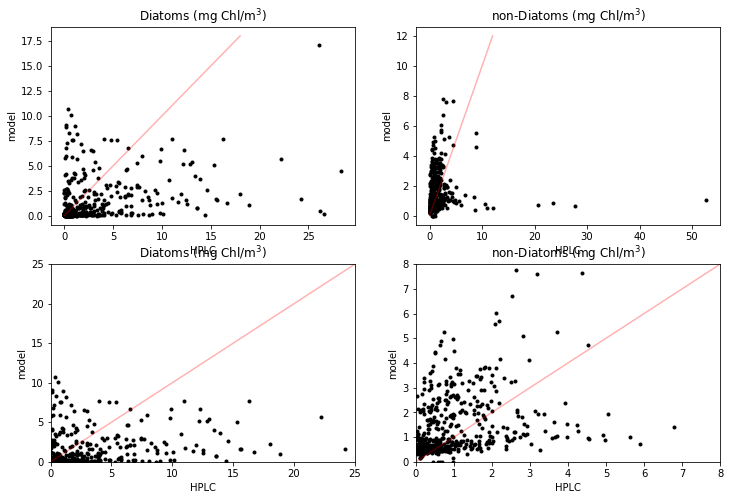

In [7]:
fig,ax=plt.subplots(2,2,figsize=(12,8))
ax=ax.flatten()
ax[0].plot(data['Diatoms-1']+data['Diatoms-2'],1.8*data['mod_diatoms'],'k.')
ax[0].set_title('Diatoms (mg Chl/m$^3$)')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')
ax[0].plot((0,18),(0,18),'r-',alpha=.3)

ax[1].plot(data['other'],1.8*(data['mod_flagellates']+data['mod_ciliates']),'k.')
ax[1].set_title('non-Diatoms (mg Chl/m$^3$)')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')
ax[1].plot((0,12),(0,12),'r-',alpha=.3)

ax[2].plot(data['Diatoms-1']+data['Diatoms-2'],1.8*data['mod_diatoms'],'k.')
ax[2].set_title('Diatoms (mg Chl/m$^3$)')
ax[2].set_xlabel('HPLC')
ax[2].set_ylabel('model')
ax[2].plot((0,25),(0,25),'r-',alpha=.3)
ax[2].set_xlim((0,25))
ax[2].set_ylim((0,25))

ax[3].plot(data['other'],1.8*(data['mod_flagellates']+data['mod_ciliates']),'k.')
ax[3].set_title('non-Diatoms (mg Chl/m$^3$)')
ax[3].set_xlabel('HPLC')
ax[3].set_ylabel('model')
ax[3].plot((0,12),(0,12),'r-',alpha=.3)
ax[3].set_xlim((0,8))
ax[3].set_ylim((0,8))

In [8]:
def logt(x):
    return np.log10(x+.001)

(-3.1, 2)

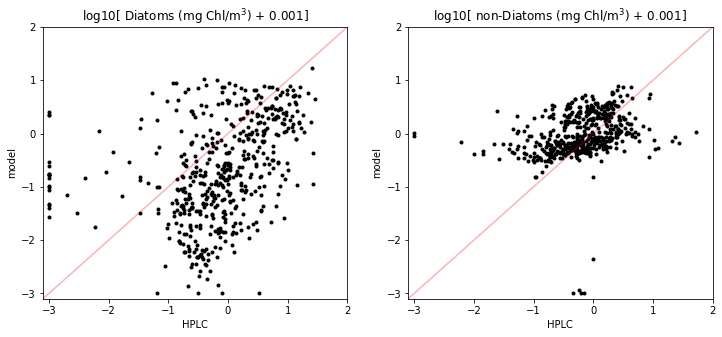

In [9]:
fig,ax=plt.subplots(1,2,figsize=(12,5))
ax[0].plot(logt(data['Diatoms-1']+data['Diatoms-2']),logt(1.8*data['mod_diatoms']),'k.')
ax[0].set_title('log10[ Diatoms (mg Chl/m$^3$) + 0.001]')
ax[0].set_xlabel('HPLC')
ax[0].set_ylabel('model')
ax[0].set_xlim(-3.1,2)
ax[0].set_ylim(-3.1,2)
ax[0].plot((-6,3),(-6,3),'r-',alpha=.3)

ax[1].plot(logt(data['other']),logt(1.8*(data['mod_flagellates']+data['mod_ciliates'])),'k.')
ax[1].set_title('log10[ non-Diatoms (mg Chl/m$^3$) + 0.001]')
ax[1].set_xlabel('HPLC')
ax[1].set_ylabel('model')
ax[1].plot((-6,3),(-6,3),'r-',alpha=.3)
ax[1].set_xlim(-3.1,2)
ax[1].set_ylim(-3.1,2)

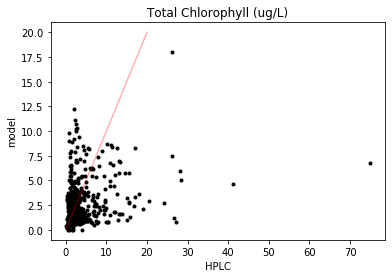

In [10]:
plt.plot(data['TchlA (ug/L)'],1.8*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms']),'k.')
plt.title('Total Chlorophyll (ug/L)')
plt.xlabel('HPLC')
plt.ylabel('model')
plt.plot((0,20),(0,20),'r-',alpha=.3)

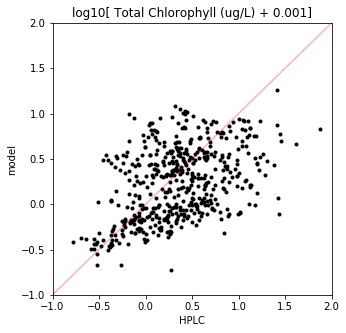

In [11]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
ax.plot(logt(data['TchlA (ug/L)']),logt(1.8*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms'])),'k.')
ax.set_title('log10[ Total Chlorophyll (ug/L) + 0.001]')
ax.set_xlabel('HPLC')
ax.set_ylabel('model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-1,2)
ax.set_ylim(-1,2);

In [12]:
def yd(idt):
    if type(idt)==dt.datetime:
        yd=(idt-dt.datetime(idt.year-1,12,31)).days
    else: # assume array or pandas
        yd=[(ii-dt.datetime(ii.year-1,12,31)).days for ii in idt]
    return yd

data['yd']=yd(data['dtUTC'])
data['Year']=[ii.year for ii in data['dtUTC']]

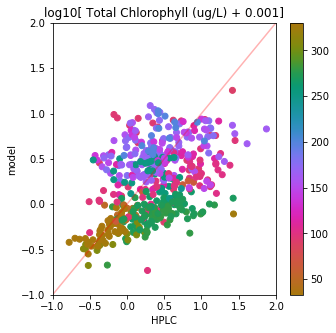

In [13]:
fig,ax=plt.subplots(1,1,figsize=(5,5))
m=ax.scatter(logt(data['TchlA (ug/L)']),logt(1.8*(data['mod_flagellates']+data['mod_ciliates']+data['mod_diatoms'])),
          c=data['yd'],cmap=cmocean.cm.phase)
ax.set_title('log10[ Total Chlorophyll (ug/L) + 0.001]')
ax.set_xlabel('HPLC')
ax.set_ylabel('model')
ax.plot((-6,5),(-6,5),'r-',alpha=.3)
ax.set_xlim(-1,2)
ax.set_ylim(-1,2);
fig.colorbar(m)

In [14]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=np.copy(mesh.variables['tmask'][0,:,:,:])
    navlat=np.copy(mesh.variables['nav_lat'][:,:])
    navlon=np.copy(mesh.variables['nav_lon'][:,:])

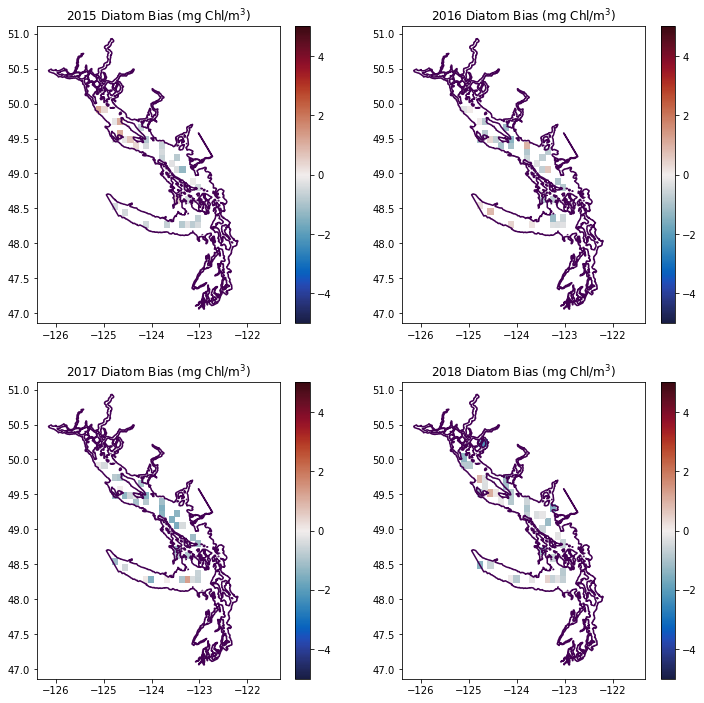

In [15]:
fig,ax=plt.subplots(2,2,figsize=(12,12))
ax=ax.flatten()
for yr in range(2015,2019):
    dyr=data.loc[(data['Year']==yr)&(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&~np.isnan(data['other'])&~np.isnan(data['mod_diatoms'])]
    ax[yr-2015].contour(navlon,navlat,tmask[0,:,:],(0.5,))
    ax[yr-2015].set_title(str(yr)+' Diatom Bias (mg Chl/m$^3$)')
    s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
                logt(1.8*dyr['mod_diatoms'])-logt(dyr['Diatoms-1']+dyr['Diatoms-2']), 
                statistic='mean', bins=20)
    m=ax[yr-2015].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-5,vmax=5,shading='flat')
    plt.colorbar(m,ax=ax[yr-2015])

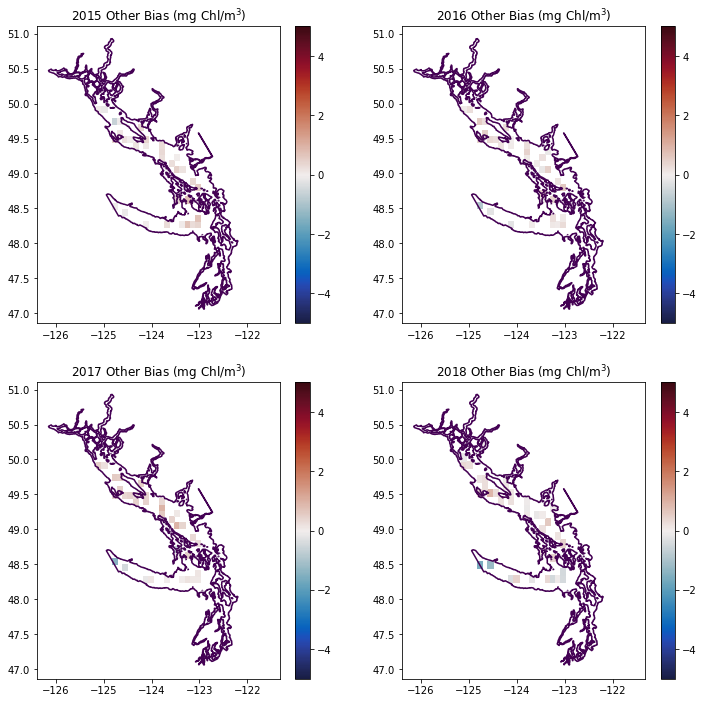

In [16]:
fig,ax=plt.subplots(2,2,figsize=(12,12))
ax=ax.flatten()
for yr in range(2015,2019):
    dyr=data.loc[(data['Year']==yr)&(~np.isnan(data['Lon']))&(~np.isnan(data['Lat']))&~np.isnan(data['other'])&~np.isnan(data['mod_diatoms'])]
    ax[yr-2015].contour(navlon,navlat,tmask[0,:,:],(0.5,))
    ax[yr-2015].set_title(str(yr)+' Other Bias (mg Chl/m$^3$)')
    s,xb,yb,nb=spst.binned_statistic_2d(dyr['Lon'],dyr['Lat'],
                logt(1.8*(dyr['mod_flagellates']+dyr['mod_ciliates']))-logt(dyr['other']), 
                statistic='mean', bins=20)
    m=ax[yr-2015].pcolormesh(xb,yb,s.T,cmap=cmocean.cm.balance,vmin=-5,vmax=5,shading='flat')
    plt.colorbar(m,ax=ax[yr-2015])

Text(0, 0.5, 'log(mod)-log(hplc)')

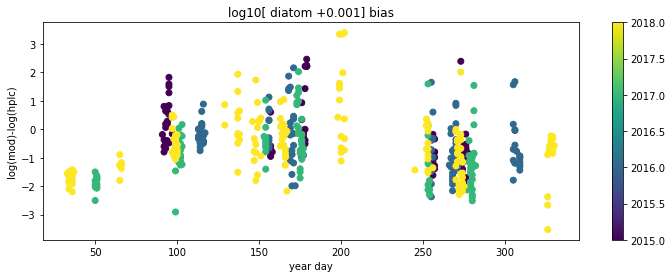

In [17]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
m=ax.scatter(data['yd'],logt(1.8*(data['mod_diatoms']))-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log10[ diatom +0.001] bias')
ax.set_xlabel('year day')
ax.set_ylabel('log(mod)-log(hplc)')

Text(0, 0.5, 'model- HPLC')

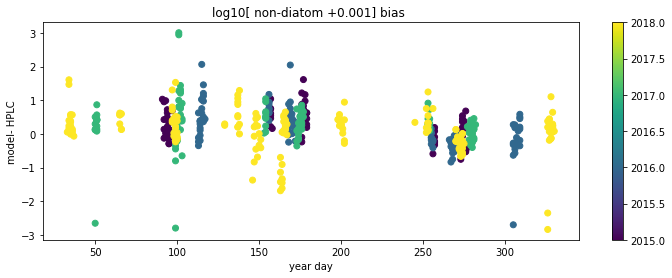

In [18]:
fig,ax=plt.subplots(1,1,figsize=(12,4))
m=ax.scatter(data['yd'],logt(1.8*(data['mod_flagellates']+data['mod_ciliates']))-logt(data['other']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log10[ non-diatom +0.001] bias ')
ax.set_xlabel('year day')
ax.set_ylabel('model- HPLC')

(-30, 25)

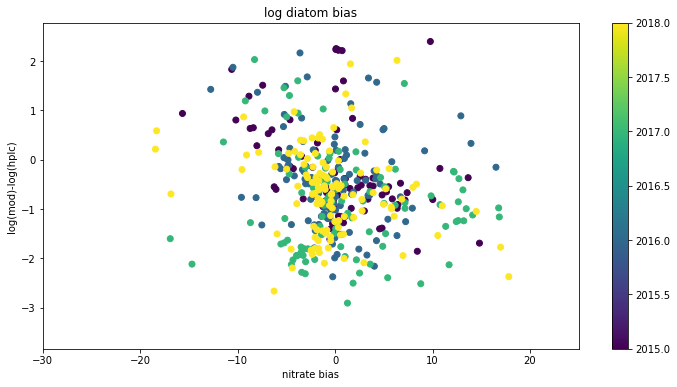

In [19]:
fig,ax=plt.subplots(1,1,figsize=(12,6))
m=ax.scatter(data['mod_nitrate']-data['Nitrate_plus_Nitrite [umol/L]'],logt(1.8*data['mod_diatoms'])-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log diatom bias')
ax.set_xlabel('nitrate bias')
ax.set_ylabel('log(mod)-log(hplc)')
ax.set_xlim(-30,25)

(-1, 30)

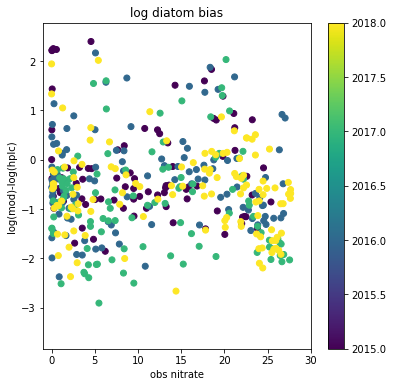

In [20]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
m=ax.scatter(data['Nitrate_plus_Nitrite [umol/L]'],logt(1.8*data['mod_diatoms'])-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log diatom bias')
ax.set_xlabel('obs nitrate')
ax.set_ylabel('log(mod)-log(hplc)')
ax.set_xlim(-1,30)

(-0.1, 3)

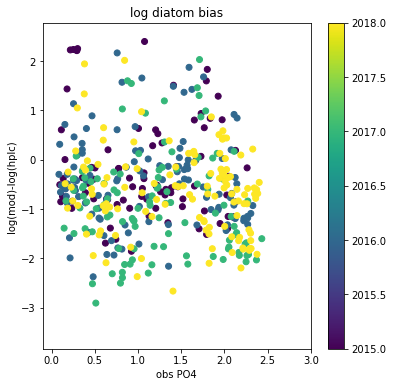

In [21]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
m=ax.scatter(data['Phosphate [umol/L]'],logt(1.8*data['mod_diatoms'])-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log diatom bias')
ax.set_xlabel('obs PO4')
ax.set_ylabel('log(mod)-log(hplc)')
ax.set_xlim(-.1,3)

(-1, 70)

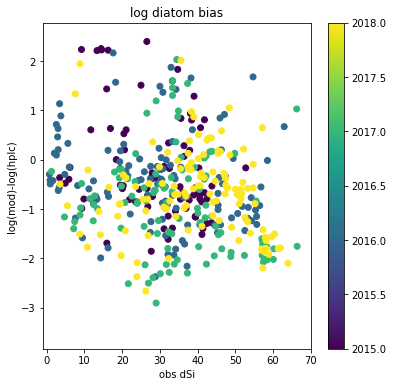

In [22]:
fig,ax=plt.subplots(1,1,figsize=(6,6))
m=ax.scatter(data['Silicate [umol/L]'],logt(1.8*data['mod_diatoms'])-logt(data['Diatoms-1']+data['Diatoms-2']),
             c=[ii.year for ii in data['dtUTC']])
plt.colorbar(m)
ax.set_title('log diatom bias')
ax.set_xlabel('obs dSi')
ax.set_ylabel('log(mod)-log(hplc)')
ax.set_xlim(-1,70)